# 3D MHD models
This notebook explains how to use cubic results of 3D MHD models on a uniform grid in CRPropa.

## Supplied data

The fields need to be supplied in a raw binary file that contains only single floats, arranged as follows: Starting with the cell values (Bx,By,Bz for magnetic field or rho for density) at the origin of the box, the code continues to read along z, then y and finally x.

On https://crpropa.github.io/CRPropa3/ under "Additional resources" you can find a number of MHD models used with CRPropa in the literature. 



### Note: 
The parameters used for the following example refer to the MHD model by Hackstein et al. (2018), as provided under "Additional resources". However, CRPropa does in general not take any warranty on the accuracy of any of those external data files.

In some previous version of this notebook the used MHD model has not been representing the results from Hackstein et al. (2018). This has been due to two issues: (1.) the size of the grid has not taken the dimensionless Hubble parameter into account and (2.) the X- and Z-coordinates of the available data files have been transposed. But since 20.05.2022 both of these issues have been fixed and the following example can be used to include the MHD model data from Hackstein et al. (2018).

In [1]:
from crpropa import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## settings for MHD model (must be set according to model)
filepath = "/rest/MagneticFields/clues"  ## directory of clues data
filename_bfield = "clues_primordial.dat" ## filename of the magnetic field
filename_halos = "clues_halos.dat"       ## filename of the halo data
filename_mass = "mass-density_clues.dat" ## filename of the mass distribution

gridOrigin = Vector3d(0,0,0)             ## origin of the 3D data, preferably at boxOrigin
gridSize = 1024                          ## size of uniform grid in data points
h = 0.677                                ## dimensionless Hubble parameter
size = 249.827/h *Mpc                    ## physical edgelength of volume in Mpc
b_factor = 1.                            ## global renormalization factor for the field

## settings of simulation
boxOrigin = Vector3d( 0, 0, 0,)          ## origin of the full box of the simulation
boxSize = Vector3d( size, size, size )   ## end of the full box of the simulation

## settings for computation
minStep = 10.*kpc                        ## minimum length of single step of calculation
maxStep = 4.*Mpc                         ## maximum length of single step of calculation
tolerance = 1e-2                         ## tolerance for error in iterative calculation of propagation step

spacing = size/(gridSize)                ## resolution, physical size of single cell

## initiate grid to hold field values
vgrid = Grid3f( gridOrigin, gridSize, spacing )
## load values to the grid
loadGrid( vgrid, os.path.join(filepath, filename_bfield), b_factor )
## use grid as magnetic field
bField = MagneticFieldGrid( vgrid )

## Source settings

The default in this example is a uniform source distribution (SourceUniformBox). To try the other examples uncomment the corresponding lines in the following cells.

In [32]:
source = Source()

#####################################################
# Uniform source distribution
#####################################################

# The most simple scenario of UHECR sources is a uniform distribution of their sources. 
# This can be realized via use of:
source.add( SourceUniformBox( boxOrigin, boxSize )) 


#####################################################
# Sampling from the density field
#####################################################

# The distribution of gas density can be used as a probability density function for 
# the injection of particles from random positions.


# initialize grid to hold field values
#mgrid = Grid1f( gridOrigin, gridSize, spacing )
# load values  to grid
#loadGrid( mgrid, os.path.join(filepath, filename_mass) )
# add source module to simulation
#source.add( SourceDensityGrid( mgrid ) )


#####################################################
# Sampling from discrete halo positions
#####################################################

# Alternatively, for the CLUES models, a list of mass halo positions is provided. 
# These positions can be used as sources with the same properties by use of the following

# read data from file
#data = np.loadtxt(os.path.join(filepath, filename_halos), unpack=True, skiprows=39)
#sX = data[0]                                                                                 
#sY = data[1]                                                                                 
#sZ = data[2]                                                                                 
#mass_halo = data[5]                                                                          
#
### find only those mass halos inside the provided volume (see Hackstein et al. 2018 for more details)
#Xdown= sX >= 0.25                                                                            
#Xup= sX <= 0.75                                                                              
#Ydown= sY >= 0.25                                                                            
#Yup= sY <= 0.75                                                                              
#Zdown= sZ >= 0.25                                                                            
#Zup= sZ <= 0.75                                                                              
#insider= Xdown*Xup*Ydown*Yup*Zdown*Zup                                                       
#
### transform relative positions to physical positions within given grid
#sX = (sX[insider]-0.25)*2*size
#sY = (sY[insider]-0.25)*2*size
#sZ = (sZ[insider]-0.25)*2*size
#
### collect all sources in the multiple sources container
#smp = SourceMultiplePositions()
#for i in range(0,len(sX)):
#    pos = Vector3d( sX[i], sY[i], sZ[i] )
#    smp.add( pos, 1. )
#    
### add collected sources
#source.add( smp )


#####################################################
# Additional source settings
#####################################################


## use isotropic emission from all sources
source.add( SourceIsotropicEmission() )

## set particle type to be injected
A, Z = 1, 1 # proton
source.add( SourceParticleType( nucleusId(A,Z) ) )

## set injected energy spectrum
Emin, Emax = 1*EeV, 1000*EeV
specIndex = -1
source.add( SourcePowerLawSpectrum( Emin, Emax, specIndex ) ) 

## Observer

To register particles, an observer has to be defined. In the provided constrained simulations the position of the Milky Way is, by definition, in the center of the volume.

In [33]:
filename_output = 'output_MW.txt'
output = TextOutput(filename_output)
output.disable(output.CandidateTagColumn)

obsPosition = Vector3d(0.5*size,0.5*size,0.5*size) # position of observer, MW is in center of constrained simulations
obsSize = 10*Mpc  ## physical size of observer sphere. Note: This is very large observer. In a real simulation the size should be reduces significantly.

## initialize observer that registers particles that enter into sphere of given size around its position
obs = Observer()
obs.add( ObserverSurface( Sphere( obsPosition, obsSize ) ) )
## write registered particles to output file
obs.onDetection( output )
## choose to not further follow particles paths once detected
obs.setDeactivateOnDetection(True)

## ModuleList

Add all created modules to the ModuleList and run the simulation.

In [34]:
N = 1000000

m = ModuleList()
m.add(PropagationCK( bField, tolerance, minStep, maxStep))

#make use of periodicity of the magnetic field model
m.add( PeriodicBox( boxOrigin, boxSize ) )

m.add(obs)

#end trajectories to speed up simulation
maxTra = MaximumTrajectoryLength(400 * Mpc)
m.add(maxTra)

#m.showModules()         ## optional, see summary of loaded modules
m.setShowProgress(True) ## optional, see progress during runtime
m.run(source, N, True)  ## perform simulation with N particles injected from source

output.close()

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Thu Feb  9 12:12:17 2023 : [ Finished ] 100%    Needed: 00:03:47  - Finished at Thu Feb  9 12:16:04 2023


2296 candidates have been recorded that is ~0.23% of all injected candidates


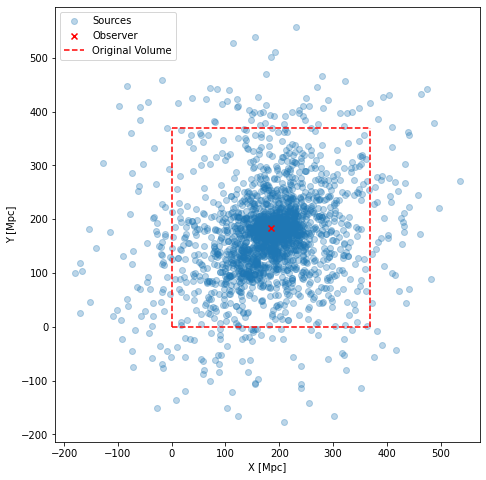

In [35]:
with open('output_MW.txt', 'r') as f:
    names = f.readline()[:-1].split('\t')[1:]

df = pd.read_csv('output_MW.txt', delimiter = '\t', comment='#', names=names)
import numpy as np

print("{} candidates have been recorded that is ~{:.2}% of all injected candidates".format(df.D.count(), df.D.count()/N*100))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.scatter(df.X0, df.Y0, alpha=0.3, label="Sources")
ax.scatter(obsPosition.x/Mpc, obsPosition.y/Mpc, marker='x', color='red', label=('Observer'))
ax.plot([0,size/Mpc], [0, 0], color='r', linestyle='--')
ax.plot([0,size/Mpc], [size/Mpc, size/Mpc], color='r', linestyle='--')
ax.plot([0,0], [0, size/Mpc], color='r', linestyle='--')
ax.plot([size/Mpc,size/Mpc], [0, size/Mpc], color='r', linestyle='--', label="Original Volume")

ax.legend(loc="upper left")
ax.set_aspect(True)

ax.set_xlabel('X [Mpc]')
ax.set_ylabel('Y [Mpc]')

plt.show()